<h1><center>IMT2118 - Ciencia de Datos Geoespaciales </center></h1>
<h2><center>E2:  Islas de calor urbanas y violencia contra la mujer en Nueva York  </center></h2>

Cuando hablamos de violencia de género, nos referimos a conductas violentas cuya motivación última es la pertenencia a un género. Según la subcomisión de estadísticas de género (SEG), durante el año 2020 hubo 44 femicidos consumados y 163 intentos frustrados $^1$. Es por esto que la violencia de género es un problema relevante, el cual requiere de la formulación de políticas públicas para ser abordado correctamente. 

Para los objetivos de este trabajo, se abordará exclusivamente la violencia ejercida desde hombres a mujeres, y limitada al siguiente subconjunto de crímenes obtenidos de las columnas de nuestro dataset:violación, acoso, secuestro, crímenes sexuales y homicidio.



**Referencias:**
1. Subcomisión de Estadísticas de Género (SEG) (n.d.). VIolencia de género. EstadíSticas de géNero. Retrieved July 2, 2023, from https://www.estadisticasdegenero.cl/indicadores/violencia-de-genero/

### 1. Importaciones y lecturas

In [23]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import geemap
from shapely.geometry import box
import numpy as np
import seaborn as sns
import libpysal as ps
from libpysal import weights
import esda

In [24]:
# ee.Authenticate()
ee.Initialize()

In [25]:
big_crimes = gpd.read_file('NYPD_violence_against_women.gpkg')
big_crimes.to_crs('EPSG:4326', inplace=True)

In [26]:
manz = gpd.read_file('squares/nyct2020.shp')
manz.to_crs('EPSG:4326', inplace=True)
manz.head(1)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry
0,1,1,Manhattan,000100,1000100,NaN,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."


c:\Users\badil\AppData\Local\Programs\Python\Python37\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

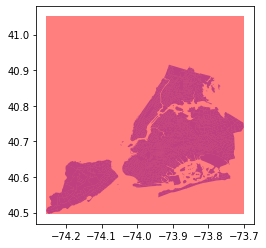

In [27]:
unif = manz.unary_union
bounding_box = unif.bounds
minx, miny, maxx, maxy = bounding_box
width = max(maxx - minx, maxy - miny)
expanded_bbox = box(minx, miny, minx + width, miny + width)
ny_box = gpd.GeoDataFrame(geometry=[expanded_bbox])
ax = manz.plot(color='blue', alpha=0.5)
ny_box.plot(ax=ax, color='red', alpha=0.5)

In [28]:
poly = ny_box.geometry.iloc[0]
xy = list(poly.exterior.coords)
aoi = ee.Geometry.Polygon([xy[0], xy[1], xy[2], xy[3]])
x = aoi.centroid().getInfo()['coordinates'][0]
y = aoi.centroid().getInfo()['coordinates'][1]
aoi2 = ee.Geometry.Point([x-.1, y-.1])

### 2. Visualización de HeatMaps

In [29]:
def cloudMask(image):
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(1 << 3).Or(qa.bitwiseAnd(1 << 4))
    return image.updateMask(mask.Not())


def applyScaleFactors(image):
    thermalband = image.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15)
    return image.addBands(srcImg=thermalband, overwrite=True)

In [30]:
# "LANDSAT/LE07/C01/T1"
# https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2

collection = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(aoi).filterDate('2022-05-30', '2022-07-10').map(cloudMask)
filtered_l8 = collection.filter(ee.Filter.lt('CLOUD_COVER', 25))
landsatST = filtered_l8.map(applyScaleFactors)
mean_landsatST = landsatST.mean()
clip_mean_ST = mean_landsatST.clip(aoi)

images=collection.aggregate_array('system:id').getInfo()
print(len(images))

7


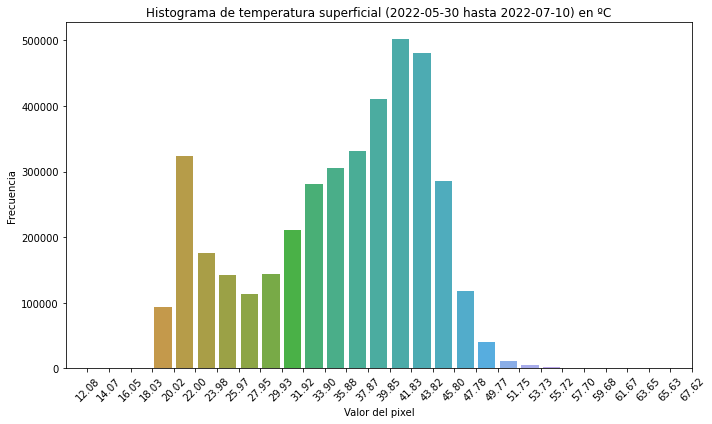

In [31]:
values_ST = clip_mean_ST.select('ST_B10')
histogram_ST = values_ST.reduceRegion(
    reducer=ee.Reducer.histogram(30),
    geometry=aoi,
    scale=30
)

values_ST = clip_mean_ST.select('ST_B10')
histogram_info = histogram_ST.get('ST_B10').getInfo()
histogram_values = histogram_info['histogram']
bucket_means = histogram_info['bucketMeans']

num_bins = len(histogram_values)
min_value = bucket_means[0] - (bucket_means[1] - bucket_means[0]) / 2
max_value = bucket_means[-1] + (bucket_means[-1] - bucket_means[-2]) / 2
bin_edges = np.linspace(min_value, max_value, num_bins + 1)

histogram_df = pd.DataFrame({'bin_edges': bin_edges[:-1], 'histogram_values': histogram_values})

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=histogram_df, x='bin_edges', y='histogram_values')
plt.xlabel('Valor del pixel')
plt.ylabel('Frecuencia')
plt.title('Histograma de temperatura superficial (2022-05-30 hasta 2022-07-10) en ºC')

tick_positions = np.arange(len(bin_edges[:-1])) + 0.5
tick_labels = [f'{val:.2f}' for val in bin_edges[:-1]]
plt.xticks(tick_positions, tick_labels)
plt.xticks(rotation=45)
plt.tight_layout()

In [32]:
Map = geemap.Map()
heat_params = {'min': 20,
    'max': 50,
    'bands': 'ST_B10',
    'palette': ['blue', 'purple', 'yellow', 'orange','red']}
Map.addLayer(clip_mean_ST, heat_params, 'ST')
Map.centerObject(aoi2, 10)
Map

Map(center=[40.673871012612906, -74.07780021318202], controls=(WidgetControl(options=['position', 'transparent…

In [33]:
heat_islands = clip_mean_ST.gt(48).selfMask()
hi_params = {
    'bands': 'ST_B10',
    'palette': 'black'}
Map.addLayer(heat_islands, hi_params, 'Heat Islands')

A continuación, veremos añadiremos al plot distintos rangos de fechas.

In [34]:
layer_list = []
for i in range(1, 11):
    col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(aoi).filterDate(f'2022-{i}-30', f'2022-{i+2}-10').map(cloudMask)
    filtered= collection.filter(ee.Filter.lt('CLOUD_COVER', 25))
    landST = filtered_l8.map(applyScaleFactors)
    mean_ST = landsatST.mean()
    clip_mean_ST = mean_landsatST.clip(aoi)
    layer_list.append(clip_mean_ST)

In [35]:
layer_list

In [36]:
Map2 = geemap.Map()
for i,layer in enumerate(layer_list):
    layer
    Map2.addLayer(layer, heat_params, f'H.I 0{i+1}-30 to {i+3}-10')

Map2.centerObject(aoi2, 10)
Map2

Map(center=[40.673871012612906, -74.07780021318202], controls=(WidgetControl(options=['position', 'transparent…

### 3. Visualizar información de crimenes

<AxesSubplot:>

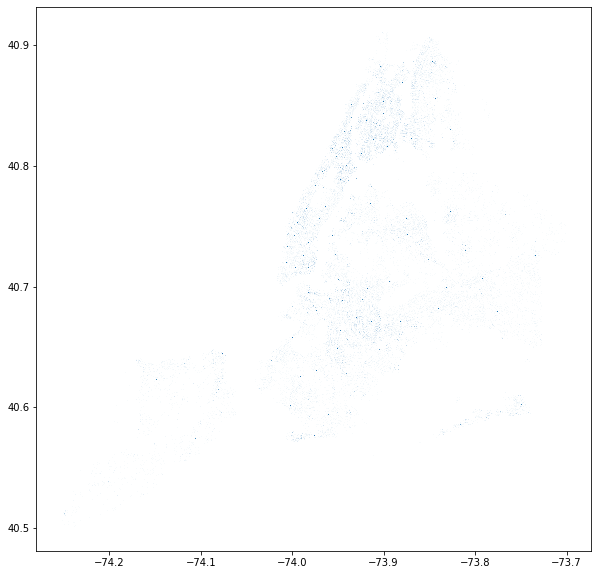

In [37]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
big_crimes.plot(ax=ax, alpha=0.1, markersize=0.01)

### 4. Normalizar información de crímenes por cantidad de mujeres para el periodo relevante (2022)

In [39]:
every_manz_crimes = list()
for i in range(len(manz)):
    n_crimes = big_crimes.within(manz.iloc[i].geometry)
    every_manz_crimes.append(sum(n_crimes))
manz["n_crimes"] = every_manz_crimes

Ahora leemos el censo 2020 de NY, y nos quedamos con las manzanas en las cuales tenemos 

In [40]:
census_tracts = gpd.read_file('census/nyc_census_tracts.csv')

In [41]:
manz_filtered = manz[manz['GEOID'].isin(census_tracts['CensusTract'].unique())]
census_filtered = census_tracts[census_tracts['CensusTract'].isin(manz['GEOID'].unique())]

In [42]:
census_filtered = census_filtered[['CensusTract', 'TotalPop', 'Women']]

In [43]:
squares = manz_filtered.merge(census_filtered, left_on='GEOID', right_on='CensusTract')
squares = squares.drop('CensusTract', axis=1)

In [44]:
def proportion(TotalPop, subgroup):
    if float(TotalPop) == 0:
        return 0
    else:
        return float(subgroup)/float(TotalPop)

In [45]:
cant_mujeres = sum(squares['Women'].astype('float64'))
squares['women_prop'] = squares.apply(lambda x: proportion(x.TotalPop, x.Women), axis=1)
squares['area_km2'] = squares.to_crs('EPSG:2263').geometry.area * 0.000000092903
squares['crimes_prop'] = squares.apply(lambda x: proportion(x.area_km2, x.n_crimes), axis=1)
squares.sample(3)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,...,PUMA,Shape_Leng,Shape_Area,geometry,n_crimes,TotalPop,Women,women_prop,area_km2,crimes_prop
820,127.01,2,Bronx,012701,2012701,NaN,Longwood,BX0202,BX02,BX02 Longwood-Hunts Point (CD 2 Approximation),...,4221,5036.141344,1.172793e+06,"POLYGON ((-73.88790 40.82674, -73.88881 40.826...",11,1992,1201,0.602912,0.108956,100.958207
1520,447,3,Brooklyn,044700,3044700,NaN,Bushwick (West),BK0401,BK04,BK04 Bushwick (CD 4 Equivalent),...,4304,5524.516488,1.752245e+06,"POLYGON ((-73.91922 40.70782, -73.92032 40.706...",3,2480,1365,0.550403,0.162789,18.428788
1372,273,3,Brooklyn,027300,3027300,NaN,Bedford-Stuyvesant (East),BK0302,BK03,BK03 Bedford-Stuyvesant (CD 3 Approximation),...,4303,5273.313949,1.611451e+06,"POLYGON ((-73.93435 40.67956, -73.93487 40.679...",16,2649,1377,0.519819,0.149709,106.874263


<AxesSubplot:>

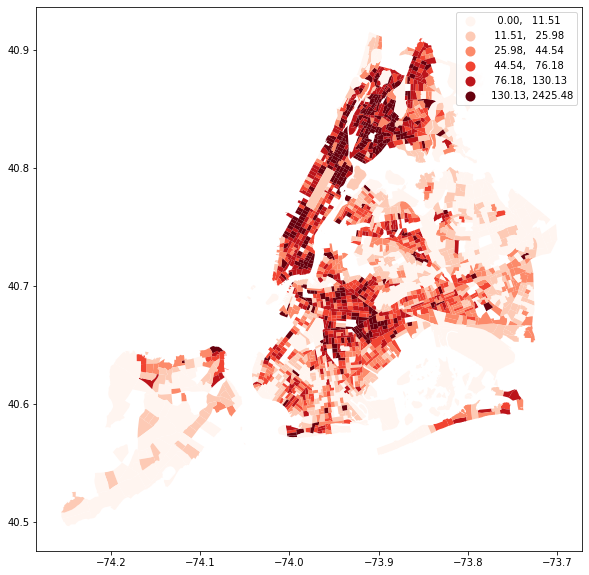

In [46]:
squares.plot(column='crimes_prop', scheme='quantiles', k=6, cmap='Reds', figsize=(10,10), legend=True)

### 5. Discretización de raster de temperatura

In [47]:
list_temp = list()
for sq in squares.iterrows():
    mean_temp = 0
    img_sq = clip_mean_ST.select('ST_B10').clip(sq[1][14])
    n_pix = len(np.array(img_sq).flatten())
    for pix in np.array(img_sq).flatten():
        print(pix)
        # mean_temp += pix
    list_temp.append(mean_temp/n_pix)

squares["mean_temperature"] = list_temp

EEException: Can't encode object: MULTIPOLYGON (((-74.04387761639944 40.69018767587401, -74.04350596078567 40.6896873596363, -74.04273533892976 40.69005019091781, -74.04278433380006 40.690120976691354, -74.04270428426766 40.6901552046445, -74.04255372037339 40.68996275979237, -74.0426392937119 40.68992817641353, -74.04269380819214 40.689997259609974, -74.04346752310298 40.68963699060623, -74.04351637245855 40.689191033742546, -74.04364078627445 40.68876656007293, -74.04397458556184 40.68858240705612, -74.04438521777247 40.68851617790029, -74.04478399106388 40.688595660115816, -74.04627539003668 40.689327425896934, -74.04680284898575 40.689953256266215, -74.0474765152837 40.689611369998204, -74.047729627631 40.689915318968794, -74.04758571924822 40.68998250732891, -74.0474312612351 40.68980389047109, -74.04689205500591 40.690059098322806, -74.04720029366251 40.69042481562394, -74.04711050698607 40.690470412850274, -74.04711582042361 40.69065580611837, -74.04718321412064 40.690747355049275, -74.04719492513735 40.690763263848375, -74.04721324567835 40.69079048732637, -74.04722568425278 40.69081957243568, -74.04723192827254 40.69084978826996, -74.04723182081725 40.69088037550697, -74.04722536457862 40.69091056549009, -74.04721272179357 40.690939599544606, -74.04719421016807 40.690966748043444, -74.0471702948939 40.69099132874267, -74.04714091053252 40.691010516344676, -74.04710814053631 40.69102620847252, -74.04707269656511 40.69103806434227, -74.0470353483505 40.69104582648133, -74.04699690697936 40.69104932632006, -74.04617167065449 40.69109798148653, -74.04614707208665 40.691122646033364, -74.04609551065151 40.69112006354922, -74.0460444245555 40.69111415266101, -74.04599418395566 40.6911049561975, -74.04592592767887 40.69108260379811, -74.04586027427413 40.691056116583574, -74.04460616482923 40.69057348495099, -74.04387761639944 40.69018767587401)), ((-74.03995040788483 40.70089063014033, -74.03945262913307 40.700533159823905, -74.03938278118848 40.70057769456149, -74.03771124796636 40.69934404034792, -74.03809786214774 40.6990395052444, -74.03822954445391 40.6983685916979, -74.03900043878028 40.69836989039119, -74.0393403767015 40.69811551483617, -74.03993272132986 40.69854442279385, -74.04025555083275 40.69880482330749, -74.04124261832222 40.699536741435054, -74.04174768868015 40.69914786356684, -74.03991248872623 40.697702040398596, -74.04166051914841 40.69645297163993, -74.04367371230778 40.69802040433027, -74.04363686211197 40.69804823269846, -74.04365651062231 40.69806409108808, -74.04270395810723 40.69880060058688, -74.04296505227515 40.69899936182236, -74.0410986123707 40.70049294338983, -74.04080080646241 40.7002685499267, -74.04031250973529 40.70062574919241, -74.04028808803947 40.70064361346732, -74.03995040788483 40.70089063014033)))

In [ ]:
clip_mean_ST.select('ST_B10').getInfo()['properties']['system:footprint']['coordinates'][0][:-1]

[[-74.25559136315213, 40.49613398761199],
 [-73.70000906321272, 40.49613398761199],
 [-73.70000906321272, 41.05171628755141],
 [-74.25559136315213, 41.05171628755141]]

In [ ]:
from time import time

#### No correr siguiente código, se importará el dataframe que se generó

In [ ]:
init = time()
# Convert the geometries to GeoJSON format
squares['geometry_geojson'] = squares['geometry'].apply(lambda x: x.__geo_interface__)

# Create an empty list to store the mean temperatures
mean_temperatures = []

# Iterate over each row of the geodataframe
for index, row in squares.iterrows():
    # Get the geometry of the row
    geometry = row['geometry_geojson']
    clipped_image = clip_mean_ST.clip(geometry)
    
    # Compute the mean temperature within the geometry
    mean_temperature = clipped_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ee.Geometry(geometry),
        scale=30
    ).get('ST_B10')
    
    # Append the mean temperature to the list
    mean_temperatures.append(mean_temperature.getInfo())
    if index%20==0:
        timer = time()
        delta = timer - init
        init = timer
        print(f'iteración {index}: {round(100*index/2034, 3)}% | Exec time: {delta}')

# Assign the mean temperatures to the 'mean_temperature' column in the geodataframe
squares['mean_temperature'] = mean_temperatures

NameError: name 'squares' is not defined

Este código demora 35 min en correr, por lo que guardamos el dataframe y lo cargamos.

In [ ]:
# squares.to_file('squares_temperature.shp', driver="ESRI Shapefile")

In [48]:
squares.to_file('squares_temperature.shp', driver="ESRI Shapefile")

### 6. Análisis de autocorrelación espacial

In [49]:
squares = gpd.read_file('cuadras_temperatura/squares_temperature.shp')
squares.sample(1)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,...,Shape_Area,n_crimes,TotalPop,Women,women_prop,area_km2,crimes_pro,geometry_g,mean_tempe,geometry
1393,294,3,Brooklyn,029400,3029400,NaN,Gravesend (West),BK1103,BK11,BK11 Bensonhurst-Bath Beach (CD 11 Approximation),...,2.032100e+06,6,2489,1408,0.565689,0.188788,31.781657,"{""type"": ""Polygon"", ""coordinates"": [[[-73.9952...",43.073749,"POLYGON ((-73.99523 40.59709, -73.99630 40.596..."


<AxesSubplot:title={'center':'Mapa de temperatura promedio (ºC) en julio 2022, NYC'}>

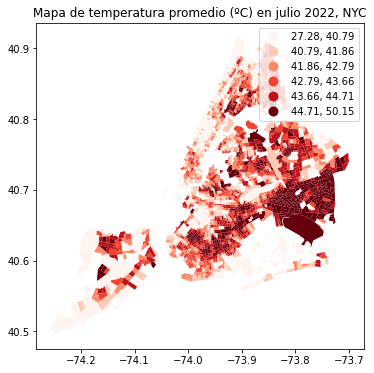

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title('Mapa de temperatura promedio (ºC) en julio 2022, NYC')
squares.plot(ax=ax, column='mean_tempe', scheme='quantiles', k=6, cmap='Reds', legend=True)

In [51]:
mean = squares.mean_tempe.mean()
sd = squares.mean_tempe.std()
squares['temp_std'] = (squares['mean_tempe'] - mean)/sd
squares['index'] = squares.index

In [52]:
squares.sample(1)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,...,TotalPop,Women,women_prop,area_km2,crimes_pro,geometry_g,mean_tempe,geometry,temp_std,index
23,55.01,1,Manhattan,005501,1005501,NaN,Greenwich Village,MN0202,MN02,MN02 Greenwich Village-SoHo (CD 2 Equivalent),...,4747,2211,0.465768,0.12435,40.208969,"{""type"": ""Polygon"", ""coordinates"": [[[-73.9965...",41.350884,"POLYGON ((-73.99657 40.72955, -73.99581 40.729...",-0.557517,23


In [53]:
w = weights.Queen.from_dataframe(squares, ids='index')

In [54]:
squares["temp_lag"] = weights.spatial_lag.lag_spatial(w, squares['temp_std'])
squares['crimes_prop_lag'] = weights.spatial_lag.lag_spatial(w, squares['crimes_pro'])

<AxesSubplot:title={'center':'Mapa de temperatura promedio (ºC) en julio 2022, NYC'}>

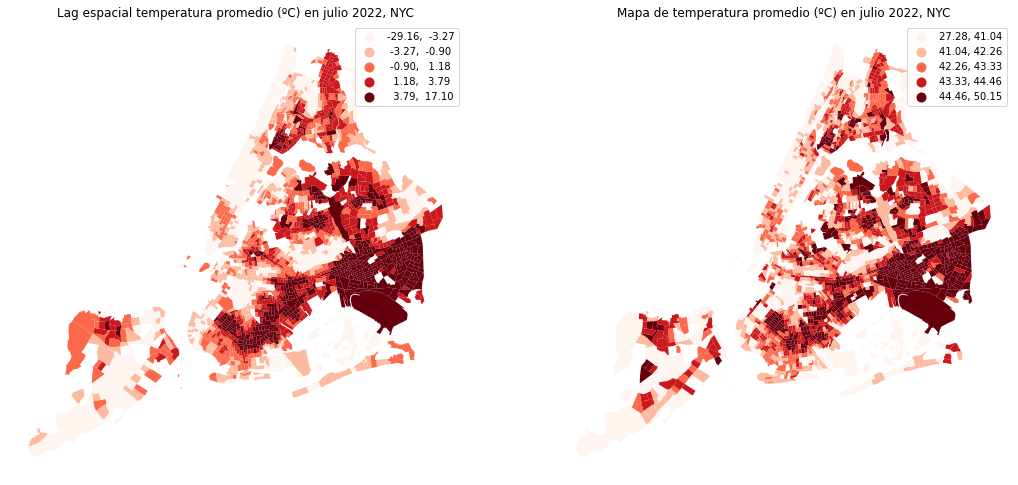

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(18, 10))
ax1 = ax[0]
ax2 = ax[1]
ax1.set_axis_off()
ax1.set_title('Lag espacial temperatura promedio (ºC) en julio 2022, NYC')
squares.plot(ax=ax1, column='temp_lag', scheme='quantiles', k=5, cmap='Reds', legend=True)

ax2.set_axis_off()
ax2.set_title('Mapa de temperatura promedio (ºC) en julio 2022, NYC')
squares.plot(ax=ax2, column='mean_tempe', scheme='quantiles', k=5, cmap='Reds', legend=True)

<Axes: title={'center': 'Crímenes de género 2022, NYC'}>

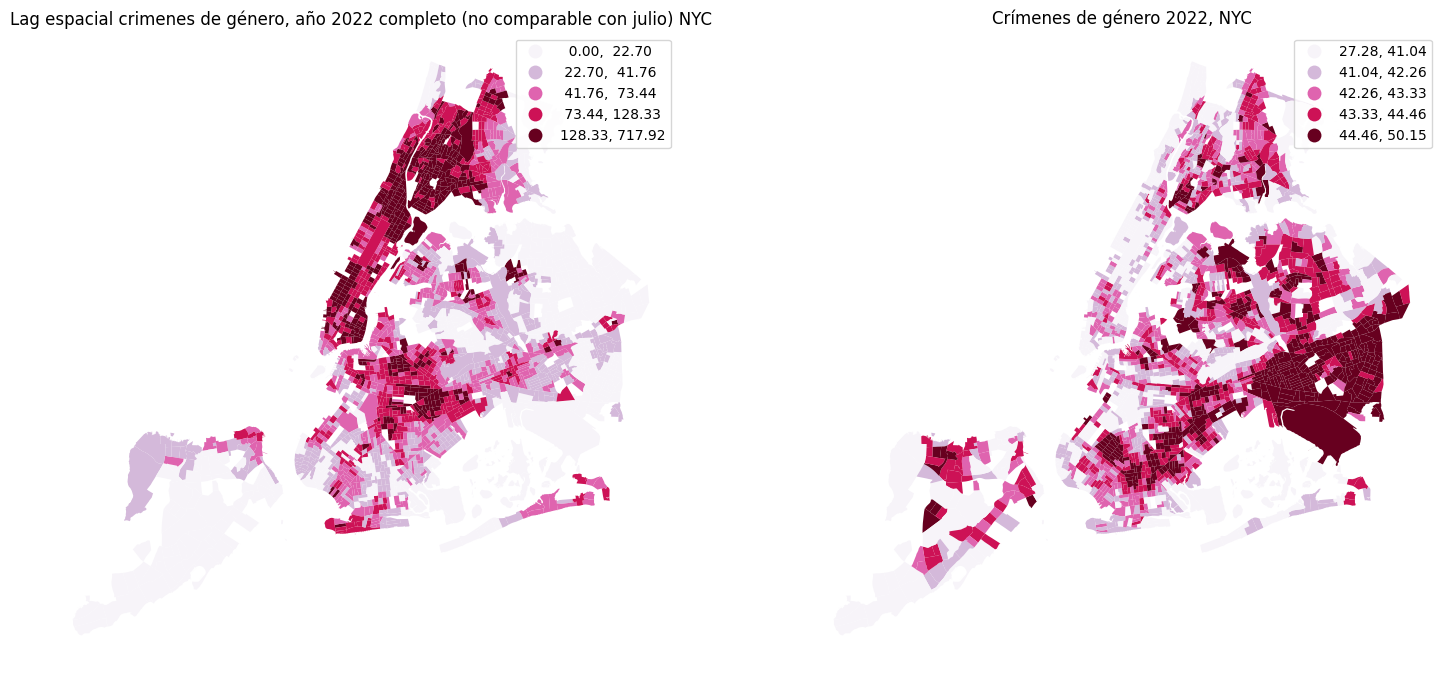

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 10))
ax1 = ax[0]
ax2 = ax[1]
ax1.set_axis_off()
ax1.set_title('Lag espacial crimenes de género, año 2022 completo (no comparable con julio) NYC')
squares.plot(ax=ax1, column='crimes_prop_lag', scheme='quantiles', k=5, cmap='PuRd', legend=True)

ax2.set_axis_off()
ax2.set_title('Crímenes de género 2022, NYC')
squares.plot(ax=ax2, column='mean_tempe', scheme='quantiles', k=5, cmap='PuRd', legend=True)

#### a. Moran Global para temperatura y crímenes

Text(0.5, 1.0, 'Gráfico de moran: temperaturas promedio en Julio 2022')

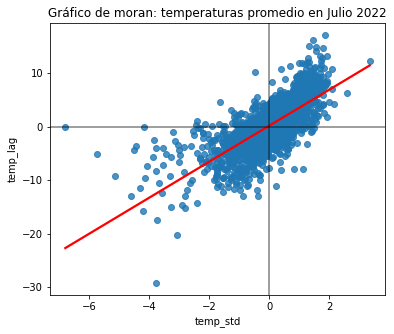

In [56]:
f, ax1 = plt.subplots(1, figsize=(6, 5))
ax1
sns.regplot(ax=ax1,
    x="temp_std",
    y="temp_lag",
    ci=None,
    data=squares,
    line_kws={"color": "r"},
)
ax1.axvline(0, c="k", alpha=0.5)
ax1.axhline(0, c="k", alpha=0.5)
ax1.set_title("Gráfico de moran: temperaturas promedio en Julio 2022")

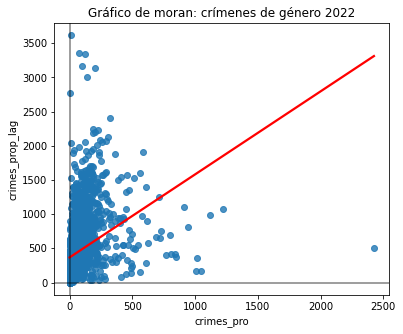

In [57]:
f, ax2 = plt.subplots(1, figsize=(6, 5))
sns.regplot(ax=ax2,
    x="crimes_pro",
    y="crimes_prop_lag",
    ci=None,
    data=squares,
    line_kws={"color": "r"},
)
ax2.axvline(0, c="k", alpha=0.5)
ax2.axhline(0, c="k", alpha=0.5)
ax2.set_title("Gráfico de moran: crímenes de género 2022")
plt.show()

In [58]:
w.transform = "R"
moran = esda.moran.Moran(squares["temp_lag"], w)
print(f'Heat -> Moran index: {moran.I} | p-value: {moran.p_sim}')

moran_crime = esda.moran.Moran(squares["crimes_prop_lag"], w)
print(f'crimenes de genero -> Moran index: {moran_crime.I} | p-value: {moran_crime.p_sim}')

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 147, ' is an island (no neighbors)')
('WARNING: ', 1174, ' is an island (no neighbors)')
Heat -> Moran index: 0.9171225382175238 | p-value: 0.001
crimenes de genero -> Moran index: 0.6872262205886382 | p-value: 0.001


Dado el alto valor del indice de Moran, y bajo valor p, hay una alta correlación global de los datos. (COMPLETAR)

#### b. Moran local para temperatura y crímenes

In [59]:
x=squares['temp_std']
y=squares['temp_lag']
lisa = esda.moran.Moran_Local(x, w)

Slope: 3.373794921745238
HH
LL
LH
HL


Text(0.5, 0.98, 'LISA para temperatura promedio')

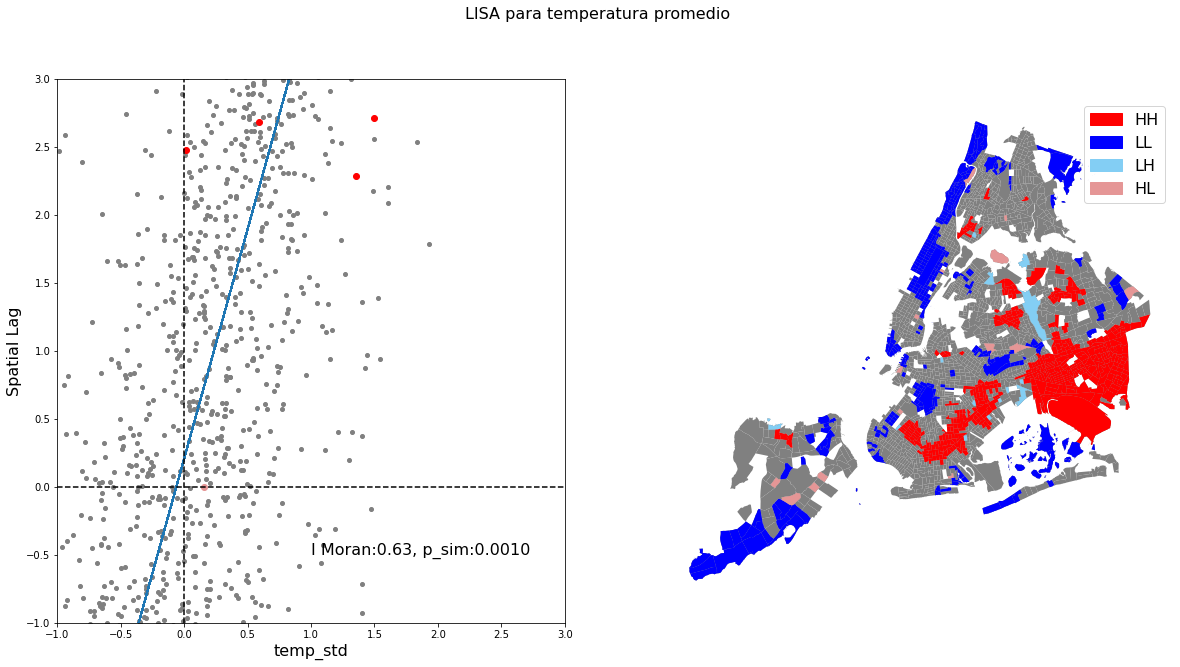

In [60]:
import matplotlib.patches as mpatches

squares['quadrant'] = lisa.q
squares['significant'] = lisa.p_sim < 0.05

quads={1:'HH',2:'LH',3:'LL',4:'HL'}
palette = {'LL': 'blue','HH':'red','LH':'#83cef4','HL':'#e59696'}

squares['quad_class'] = [quads[x] for x in squares['quadrant']]

HHm=(squares['significant']) & (squares['quadrant']==1) 
LLm=(squares['significant']) & (squares['quadrant']==3) 
HLm=(squares['significant']) & (squares['quadrant']==4) 
LHm=(squares['significant']) & (squares['quadrant']==2)

f,(ax,ax2) = plt.subplots(1,2, figsize=(20, 10))

m,b= np.polyfit(x, y, 1)
print('Slope:',m)
ax.plot(x,y,'o',color='gray',markersize=4)

ax.plot(x[HHm],y[HHm],'o',color='r',markersize=6)
ax.plot(x[LLm],y[LLm],'o',color='b',markersize=6)
ax.plot(x[LHm],y[LHm],'o',color='#83cef4',markersize=6)
ax.plot(x[HLm],y[HLm],'o',color='#e59696',markersize=6)

ax.plot(x,m*x+b,ls='--')
ax.set_xlabel('temp_std',fontsize=16)
ax.set_ylabel('Spatial Lag' ,fontsize=16)
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)
ax.axhline(y=0,ls='--',color='k')
ax.axvline(x=0,ls='--',color='k')

mi = esda.moran.Moran(x, w)
ax.text(1,-0.5,'I Moran:%.2f, p_sim:%.4f'%(mi.I,mi.p_sim),fontsize=16)

sig=squares[squares['significant']]
squares.plot(color='gray',ax=ax2)

datsig={'HH':HHm,'LL':LLm,'LH':LHm,'HL':HLm}
handles=[]

for ctype in datsig.keys():
    print(ctype)
    data=squares[datsig[ctype]]
    # Definir color para cada grupo
    color = palette[ctype]
    
    # Graficar grupo en el color correspondiente y agregar a leyenda
    hand=data.plot(color=color,ax=ax2,label=ctype)
    handles.append(mpatches.Patch(color=color, label=ctype))

plt.legend(handles=handles,loc='best',fontsize=16)
ax2.set_axis_off()
f.suptitle('LISA para temperatura promedio', size=16)

Slope: 3.373794921745238
HH
LL
LH
HL


Text(0.5, 0.98, 'LISA para crímenes de género')

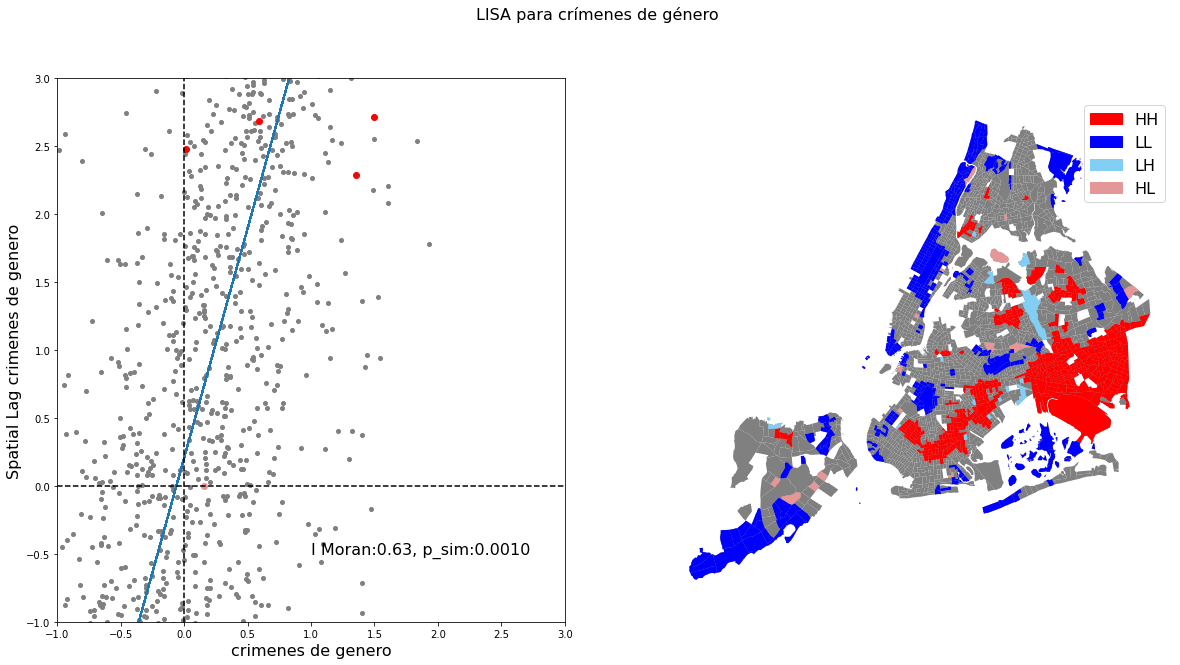

In [62]:
x_crime=squares['temp_std']
y_crime=squares['temp_lag']
lisa_crime = esda.moran.Moran_Local(x_crime, w)
squares['quadrant_crime'] = lisa.q
squares['significant_crime'] = lisa.p_sim < 0.05

squares['quad_class'] = [quads[x] for x in squares['quadrant_crime']]

HHm=(squares['significant_crime']) & (squares['quadrant_crime']==1) 
LLm=(squares['significant_crime']) & (squares['quadrant_crime']==3) 
HLm=(squares['significant_crime']) & (squares['quadrant_crime']==4) 
LHm=(squares['significant_crime']) & (squares['quadrant_crime']==2)

f,(ax,ax2) = plt.subplots(1,2, figsize=(20,10))

m,b= np.polyfit(x_crime, y, 1)
print('Slope:',m)
ax.plot(x_crime,y_crime,'o',color='gray',markersize=4)

ax.plot(x_crime[HHm],y_crime[HHm],'o',color='r',markersize=6)
ax.plot(x_crime[LLm],y_crime[LLm],'o',color='b',markersize=6)
ax.plot(x_crime[LHm],y_crime[LHm],'o',color='#83cef4',markersize=6)
ax.plot(x_crime[HLm],y_crime[HLm],'o',color='#e59696',markersize=6)

ax.plot(x_crime,m*x_crime+b,ls='--')
ax.set_xlabel('crimenes de genero',fontsize=16)
ax.set_ylabel('Spatial Lag crimenes de genero' ,fontsize=16)
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)
ax.axhline(y=0,ls='--',color='k')
ax.axvline(x=0,ls='--',color='k')

mi = esda.moran.Moran(x, w)
ax.text(1,-0.5,'I Moran:%.2f, p_sim:%.4f'%(mi.I,mi.p_sim),fontsize=16)

sig=squares[squares['significant_crime']]
squares.plot(color='gray',ax=ax2)

datsig={'HH':HHm,'LL':LLm,'LH':LHm,'HL':HLm}
handles=[]

for ctype in datsig.keys():
    print(ctype)
    data=squares[datsig[ctype]]
    # Definir color para cada grupo
    color = palette[ctype]
    
    # Graficar grupo en el color correspondiente y agregar a leyenda
    hand=data.plot(color=color,ax=ax2,label=ctype)
    handles.append(mpatches.Patch(color=color, label=ctype))

plt.legend(handles=handles,loc='best',fontsize=16)
ax2.set_axis_off()
f.suptitle('LISA para crímenes de género', size=16)

Añadir interpretación

preguntas: Falta sacar heat islands. Podríamos ver quiza el moran de las heat islands? 

ola alfonso : ¿Cómo mezclar variables? Chat gpt recomienda sacar corr entre lag espacial del calor, y lag espacial de los crimenes, pero debemos considerar los tiempos de los crímenes. O como dijo la profe, si las heat islands son constantes en el tiempo, podríamos mostrar eso, y dps podemos usar todos los crímenes. :0, que opinas?

# oli voy a ver los crimenes por meses

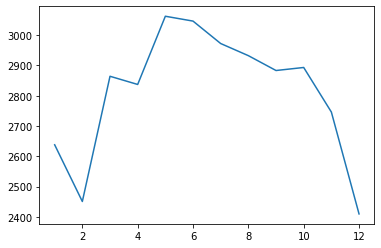

In [69]:
month_each_crime = [int(date[5:7]) for date in list(big_crimes["CMPLNT_FR_DT"])]
crimes_by_month  = [month_each_crime.count(month) for month in range(1, 13)]
plt.plot(range(1, 13), crimes_by_month)

Golazo ono